In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  # p<0.05, Stationary

In [3]:
ten_stocks_close = pd.read_csv('close_df.csv')

In [4]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

In [5]:
close_price = ten_stocks_close['600664.XSHG'].dropna()

## Ljung Box Test on close price

In [6]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(close_price, lags=[12], return_df=True) # The p-value closes to 0. Has dependency

,lb_stat,lb_pvalue
12,15870.439086,0.0


## Stationarity on close price first

In [7]:
test_stationarity(close_price) # p-value is larger than 0.05. Has unit root

Results of Dickey-Fuller Test:
Test Statistic                   -1.572222
p-value                           0.497530
#Lags Used                       13.000000
Number of Observations Used    1412.000000
Critical Value (1%)              -3.434990
Critical Value (5%)              -2.863589
Critical Value (10%)             -2.567861
dtype: float64


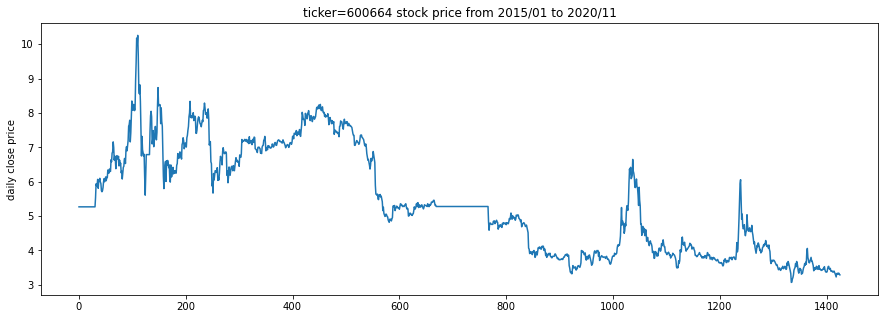

In [8]:
# visualize daily close data, lable y = column 1, ticker = 600664
close_price.plot(figsize=(15,5))
plt.ylabel('daily close price')
plt.title('ticker=600664 stock price from 2015/01 to 2020/11')
plt.show()

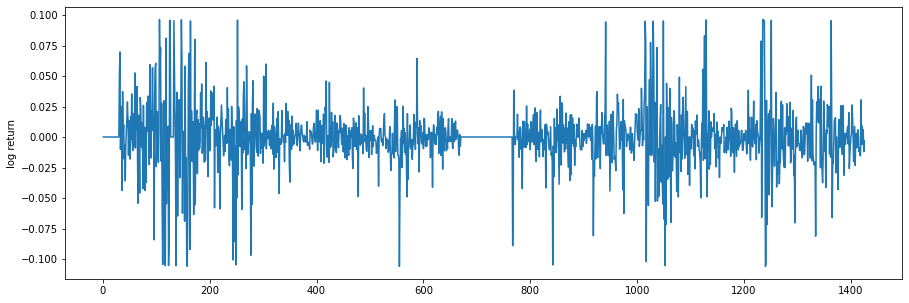

In [9]:
log_rtn = np.log(close_price).diff(1).dropna()
log_rtn.plot(figsize=(15,5))
plt.ylabel('log return')
plt.show()

## Test stationarity

In [10]:
test_stationarity(log_rtn) #p-value is small, it's stationary

Results of Dickey-Fuller Test:
Test Statistic                -1.343230e+01
p-value                        3.991559e-25
#Lags Used                     9.000000e+00
Number of Observations Used    1.415000e+03
Critical Value (1%)           -3.434980e+00
Critical Value (5%)           -2.863585e+00
Critical Value (10%)          -2.567859e+00
dtype: float64


## ACF & PACF

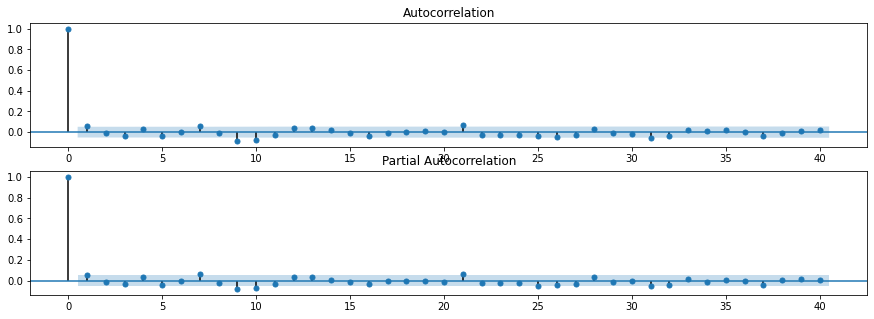

In [11]:
# acf & pacf for log return
import statsmodels.api as sm
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_rtn, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_rtn, lags=40, ax=ax2)

## Distribution of log return

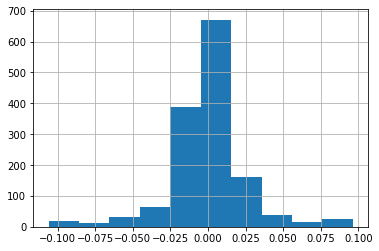

In [12]:
log_rtn.hist()
plt.show()

## Fit ARMA Model

In [13]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(5)
q = range(5)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)
def train_ARMA(param):
    try:
        p = param[0]
        q = param[1]
        model = ARIMA(log_rtn, order=(p,0,q))

        model_fit = model.fit(disp=0)

        ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12-p-q], return_df=True).values[0][1]
        aic = model_fit.aic
        return {'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}
    except:
        print(param)

results = pd.DataFrame(columns=['p', 'q', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_ARMA(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

,p,q,ljung_p,aic
17,3.0,3.0,0.824148,-6386.259693
22,4.0,3.0,0.892083,-6386.257273
18,3.0,4.0,0.888384,-6386.223495
11,2.0,2.0,0.844047,-6384.402406
23,4.0,4.0,0.764933,-6384.089399
16,3.0,2.0,0.787650,-6383.733322
12,2.0,3.0,0.786721,-6383.728475
13,2.0,4.0,0.914522,-6381.740696
21,4.0,2.0,0.911896,-6381.733600
3,0.0,4.0,0.580228,-6377.490453


## GARCH

In [14]:
mean = log_rtn.mean() # The mean closes to 0

### Check if volatility time dependency

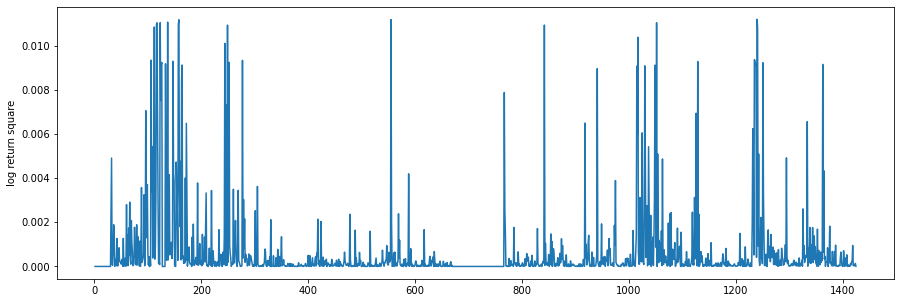

In [15]:
#log return square 
log_rtn_square = np.square(log_rtn - mean)
log_rtn_square.plot(figsize=(15,5))
plt.ylabel('log return square')
plt.show()

In [16]:
import statsmodels.api as sm

p_2 = sm.stats.acorr_ljungbox(log_rtn_square, lags=[40], return_df=True)['lb_pvalue'].values[0] # log return square is white noise if p < 0.05

print(f"P-value for squared log return: {p_2}")
if (p_2<0.05):
    print("Conclusion: Has ARCH's property in log rtn")
else:
    print("Conclusion: No ARCH's property in log rtn")

P-value for squared log return: 1.447162281109525e-263
Conclusion: Has ARCH's property in log rtn


In [17]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_GARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, mean='constant', p=p, q=q)
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    
    return {'p':p, 'q': q, 'alpha': res.params['alpha[1]'], 'beta': res.params['beta[1]'], 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'alpha', 'beta', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_GARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3510.414568336057
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3509.4525513630356
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3508.5344168632328
            Iterations: 19
            Function evaluations: 230
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3497.3362678831613
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3498.0469634017545
            Iterations: 7
            Function evalu

,p,q,alpha,beta,ljung_p,aic
0,1.0,1.0,0.100000,0.880000,0.154761,-7012.829137
1,1.0,2.0,0.200000,0.390000,0.274612,-7008.905103
2,1.0,3.0,0.200000,0.260000,0.211780,-7005.068834
3,2.0,1.0,0.050000,0.880000,0.115042,-6984.672536
4,2.0,2.0,0.100000,0.390000,0.183780,-6984.093927
5,2.0,3.0,0.100000,0.260000,0.117623,-6980.542577
6,3.0,1.0,0.033473,0.879873,0.107875,-6960.636623
8,3.0,3.0,0.066667,0.260000,0.100120,-6960.313100
7,3.0,2.0,0.066667,0.390000,0.152045,-6959.408859


## EGARCH

In [18]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_EGARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, vol='EGARCH', mean='constant', p=p, q=q, dist='t')
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    return {'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

for pq in combinations:
    try:
        results = results.append(train_EGARCH(pq), ignore_index=True)
    except:
        continue

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 8903.834984278514
            Iterations: 21
            Function evaluations: 180
            Gradient evaluations: 20
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5845.785916343197
            Iterations: 13
            Function evaluations: 142
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 62114.357150951524
            Iterations: 14
            Function evaluations: 149
            Gradient evaluations: 12


C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Iteration limit reached    (Exit mode 9)
            Current function value: -3853.1610231209625
            Iterations: 100
            Function evaluations: 912
            Gradient evaluations: 98
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4164.257216996141
            Iterations: 14
            Function evaluations: 172
            Gradient evaluations: 14
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4310.879352731972
            Iterations: 18
            Function evaluations: 186
            Gradient evaluations: 18


C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Iteration limit reached    (Exit mode 9)
            Current function value: 33175.589264396214
            Iterations: 100
            Function evaluations: 1120
            Gradient evaluations: 97
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6261.798036966587
            Iterations: 12
            Function evaluations: 173
            Gradient evaluations: 11


C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


,p,q,params,ljung_p,aic
3,2,2,mu -9.645210e-07 omega 1.629708e...,0.999994,-7692.322046
4,2,3,mu -1.686125e+00 omega -4.905167e...,1.000000,8344.514434
5,3,1,mu 3.155883 omega -2.154935 al...,1.000000,8635.758705
1,1,2,mu -10.224752 omega 1.623621 al...,1.000000,11703.571833
7,3,3,mu 2.733978 omega -1.088058 al...,0.995329,12541.596074
0,1,1,mu 40.785016 omega -0.552701 al...,1.000000,17817.669969
